In [107]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

from scipy.interpolate import interp1d

import random

from sympy import *
    
import io_utilities as ioutil

#from IPython.core.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')



![title](figs/COMPGEOP_TITLE.jpg)

### <h1><center>Module 7: Differentiation and Discretization</center></h1>

This module is largely focused on theory and practice of taking **analytic** partial differential equations (PDEs) defined on a **continuum** such as the 1D advection equation

$$\frac{\partial U}{\partial x} = \frac{1}{c}\frac{\partial U}{\partial t} \tag{1} $$

and replacing it with a **discretized** version that is appropriate for generating **numerical solutions** on **discrete computational grid**.  

Why are we interested in doing such a thing? The answer largely lies in the fact that there are only a limited number of analytical solutions to almost all PDEs that are restricted to idealized scenarios (e.g., homogeneous medium, simple boundary conditions).  The real world, though, is inherently complex and cannot be simply defined by these idealized analytic scenarios. To address these situations, we must turn to **numerical solutions** of these PDEs.  In doing so, however, we run into a whole new class of challenges including **numerical stability**, **approximation accuracy**, **computational efficiency** to name just a few. The purpose of this module is to start introducing some of these concepts within the context of numerical **differentiation** and **discretization**.   

## The Derivative Definition

Let's begin this module with a quick refresher on the definition of the derivative.  In your study of calculus over the previous number of years, you have no doubt encountered the following definition of the first derivative of function $f(t)$ defined on some interval $t\in[a,b]$:

$$ f^\prime(t) = \lim_{\Delta t\rightarrow 0} \frac{f(t+\Delta t)-f(t)}{\Delta t},  \tag{2}$$

where the $^\prime$ symbol indicates the derivative, and a small increment $\Delta t$. There are a number of other criteria that needs to be considered (e.g., continuity, differentiability); however, in this course we will assume that the functions under consideration are well-behaved such that these are not an issue.

### The Limits of Limits

Because we are interested in **discrete** solutions in this module, we are dealingt with scenarios where we have some minimum **discrete** sampling of the continuous time axis: $\Delta t$. In these scenarios, we cannot take the limit of $\Delta t \rightarrow 0$ as is required by definition of the derivative.  Thus, we are left with a **numerical approximation** of the continuous derivative:

$$ f^\prime(t) = \frac{df}{dt} \approx \frac{\Delta f}{\Delta t} = \frac{f(t+\Delta t)-f(t)}{\Delta t}. \tag{3}$$

Note that we have had to introduce the approximate symbol $\approx$ since these are not formally equal.  However, we can introduce equality by rewriting this equation as


$$ f^\prime(t) = \frac{df}{dt} = \frac{f(t+\Delta t)-f(t)}{\Delta t} +\mathcal{O}(\Delta t^2), \tag{4}$$

where $\mathcal{O}(\Delta t^2)$ indicates that there are **higher-order terms** proportional to at least $\Delta t^2$ that contribute to this equation in this case **second-order** terms such that equation 4 represents a **first-order approximation**.  Generally speaking, the $\mathcal{O}(\Delta t^2)$ is assumed and is only written when required for clarity.

## Taylor Series

Let's now bring in Taylor Series to help us better understand why the above expression is only a first-order expression.  Recall that Taylor's theorem with remainder gives the following expression:

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!}.\tag{5}$$

Rearranging this equation leads to the following:

$$\frac{f(t+\Delta t) - f(t)}{\Delta t} -f^\prime(t) =  \Delta t \frac{f^{\prime\prime}(t)}{2!},\tag{6}$$

the right-hand side of which tells us that the **numerical error** is proportional to $\Delta t$ and thus it is a **first-order approximation**.  

### Forward and Backward Approximations

So far, it is likely that you have been thinking of $\Delta t$ as a small **positive** quantity; however, we did not formally include positivity in its definition.  This definition is called a **forward approximation** of $f^\prime(t)$ because it is defined using information at $t$ and $t+\Delta t$, which is $\Delta t$ forward of $t$.

Let's now say that we have new small **negative** quantity $\Delta t^\prime$ such that $\Delta t^\prime=-\Delta t$.  How does this affect the expression in equation 6?

$$\frac{f(t-\Delta t^\prime) - f(t)}{-\Delta t^\prime} - f^\prime(t) = \frac{f(t) - f(t-\Delta t^\prime) }{\Delta t^\prime} - f^\prime(t) = - \Delta t^\prime \frac{f^{\prime\prime}(t)}{2!} ,\tag{7}$$

Thus, the middle equality of equation 7 has the same form as equation 6; however, it now requires information at $t$ and $t-\Delta t$, which $\Delta t$ units back of $t$. Thus, this expression is called a **backward approximation** of $f^\prime(t)$.  You'll also note that the error is again proportional to $\Delta t^\prime$ and thus, as should perhaps be expected, this is a **first-order approximation** just like in equation 6.

## Higher-order Taylor Series Approximations

Let's now look at combining different Taylor Series approximations to see if we can generate a higher-order expression.  Here are the forward and backward approximations defined above, but expanded out to a higher order:

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}, \tag{8a}$$
$$f(t-\Delta t) = f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}. \tag{8b}$$

Now, by subtracting equation 8b from equation 8a we can obtain the following:

$$f(t+\Delta t) - f(t-\Delta t) = 2 \Delta t f^\prime(t) + 2 \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!} \tag{9a}$$

Rearranging this expression yields:

$$\frac{f(t+\Delta t)-f(t-\Delta t)}{2\Delta t} - f^\prime(t) = 2 \Delta t^2 \frac{f^{\prime\prime\prime}(t)}{3!}. \tag{9b}$$

Unlike equation 7, you'll notice that the right-hand side error term is now proportional to $\Delta t^2$. Thus, this represents a **second-order centered approximation** of $f^\prime(t)$.

Can we go even higher? The answer is yes. However, the mathematics get a bit tedious.  I'll show a **fourth-order approximation** can be derived.

$$
\begin{eqnarray}
f(t+\Delta t) &=& f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ \Delta t^4 \frac{f^{(4)}(t)}{4!}+ \Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10a} \\
f(t-\Delta t) &=& f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{(4)}(t)}{3!}+ \Delta t^4 \frac{f^{\prime\prime\prime}(t)}{4!}- \Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10b} \\
f(t+2\Delta t) &=& f(t) + 2\Delta t f^\prime(t) + 4\Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + 8\Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ 16\Delta t^4 \frac{f^{(4)}(t)}{4!}+ 32\Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10c}\\
f(t-2\Delta t) &=& f(t) - 2\Delta t f^\prime(t) + 4\Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - 8\Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ 16\Delta t^4 \frac{f^{(4)}(t)}{4!}- 32\Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10d}\\
\end{eqnarray}$$

If we first subtract equation 10b from equation 10a and multiply by 8, we can obtain:

$$8f(t+\Delta t)-8f(t-\Delta t) = 16 \Delta t f^\prime(t)+\frac{16\Delta t ^3}{3!}f^{\prime\prime\prime}(t)+\frac{16\Delta t^5}{5!}f^{(5)}(t)\tag{10e}$$

If we then subtract equation 10d from equation 10c we can get:

$$f(t+2\Delta t)-f(t-2\Delta t) = 4 \Delta t f^\prime(t)+\frac{16\Delta t^3}{3!}f^{\prime\prime\prime}(t)+\frac{64\Delta t^5}{5!}f^{(5)}(t)\tag{10f}$$

Finally, if we subtract equation 10e from equation 10f we obtain

$$f(t+2\Delta t)-8f(t+\Delta t)+8f(t-\Delta t)-f(t-2\Delta t) - 12 \Delta t f^\prime(t) = \frac{48\Delta t^5}{5!}f^{(5)}\tag{10g} $$

Dividing through by $12 \Delta t$ yields:

$$\frac{f(t+2\Delta t)-8f(t+\Delta t)+8f(t-\Delta t)-f(t-2\Delta t)}{12 \Delta t} -  f^\prime(t) = \frac{4\Delta t^4}{5!}f^{(5)}\tag{10g} $$

Thus, after all of this math, we see that the right-hand side error term is proportional to $
\Delta t^4$ and thus equation 10g represents a **fourth-order centered approximation** of $f^\prime(t)$.  There are other expressions for higher-order approximations as well; however, these get much much more tedious ...

### A simplifying notation

Writing equation 10g in the full form can also be tedious; however, there is a fairly **compact** and general way to represent **nth-order centered approximations** (where $n$ is an even integer) of the first derivative:

$$f^\prime(t) \approx \frac{1}{\Delta t}\sum_{k=-n/2}^{n/2} c_n f(t+k\Delta t), \tag{11}$$

where $c_n$ are [finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient).  Thus, for equation 10g, if we set $n=4$ and then define $c_n = [c_{-2},c_{-1},c_0,c_1,c_2] = [\frac{1}{12},\frac{-2}{3},0,\frac{2}{3},\frac{-1}{12}]$, we see that equation 11 can represent equation 10g.

A more complete list for second- through eight-order approximations are given in Table 1 below.  You'll notice that all of the coefficients are **odd** such that $c_{-n}=-c_n$.

Derivative|Accuracy| −4	 | −3   | −2 |	−1 | 0 | 1 |  2  |  3  | 4 
----------|--------|-----|------|----|-----|---|---|-----|-----|---
1         |	  2	   |	 |      |	 |−1/2 | 0 |1/2|     |     |   				
1         |   4	   |	 |	    |1/12|−2/3 | 0 |2/3|−1/12|	   |
1         |   6	   |	 |−1/60 |3/20|−3/4 | 0 |3/4|−3/20|1/60 | 		
1         |   8	   |1/280|−4/105|1/5 |−4/5 | 0 |4/5| −1/5|4/105| −1/280	

**Table 1. List of finite-difference coefficients for centered first derivatives corresponding to the compact notation in equation 11.**


## Higher-order derivatives

So far we have just been discussing approximations for first derivatives; however, in the following modules we will be definitely be seeing second derivatives.  To see how approximations for $f^{\prime\prime}(t)$ can be generated, let's start with equations 8a and 8b

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ \Delta t^4 \frac{f^{\prime\prime\prime}(t)}{4!}, \tag{12a}$$
$$f(t-\Delta t) = f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+\Delta t^4 \frac{f^{\prime\prime\prime}(t)}{4!}. \tag{12b}$$

and then add them (rather than subtract) to yield

$$f(t+\Delta t) + f(t-\Delta t)= 2 f(t) + 2\Delta t^2 \frac{f^{\prime\prime}(t)}{2!}+ 2\Delta t^4 \frac{f^{\prime\prime}(t)}{4!}, \tag{13a}$$

Rearranging terms, cancelling out 2/(2!), and dividing through by $\Delta t^2$ results in

$$\frac{f(t+\Delta t) -2f(t) + f(t-\Delta t)}{\Delta t^2} - f^{\prime\prime}(t) = \frac{\Delta t^2}{12} f^{\prime\prime}(t). \tag{13b}$$

Thus, the expression in equation 13b represents a **second-order centered approximation** of $f^{\prime\prime}(t)$.

As one might expect from the section above, one can manipulate the Taylor-series expansions in order to create **higher-order** second derivatives.

A more complete list for second- through eight-order approximations for second derivatives are given in Table 2 below.  You'll notice that all of the coefficients are **even** such that $c_{-n}=c_n$.

Derivative|Accuracy| −4	 | −3   | −2 |	−1 | 0 | 1 |  2  |  3  | 4 
----------|--------|-----|------|----|-----|---|---|-----|-----|---
2         |	  2	   |	 |      |	 | 1   |-2 | 1 |     |     |   				
2         |   4	   |	 |	    |-1/12|4/3 | -5/2 |4/3|−1/12|	   |
2         |   6	   |	 | 1/90 |-3/20| 3/2 | -49/18 |3/2|−3/20|1/90 | 		
2         |   8	   |-1/560|8/315|-1/5 |8/5 | -205/72 |8/5| −1/5| 8/315| −1/560	

**Table 1. List of finite-difference coefficients for centered second derivatives corresponding to the compact notation in equation 11.**


### Handling (Combinations of) Partial Derivatives

In almost all cases we will be looking at solving PDEs that are of at least two variables (e.g., $U(x,t)$).  Thus, how do we approach discritzation in these scenarios? Actually, this case is pretty straightforward. Let's say that we're looking to obtain a discretized version of the following using a second-order approximation of the first spatial derivative.  This would imply that

$$\frac{\partial U(x,t)}{\partial x} \approx \frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x}.\tag{14a}$$

Similarly, if we want to obtain a discretized version of the following using a second-order approximation of the first temporal derivative, this would imply that

$$\frac{\partial U(x,t)}{\partial t} \approx \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2\Delta t}.\tag{14b}$$

Thus, combining equations 14a and 14b, if wanted to have a discrete version of both partial derivatives, then we'd have 

$$\frac{\partial U(x,t)}{\partial x}+\frac{\partial U(x,t)}{\partial t} \approx \frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x} + \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2\Delta t} \tag{14c} $$

We see that the effective **partial differential operator** on the left-hand side generates the following pattern called a **finite-difference stencil** on the right-hand side that consists of the four points visualized below:

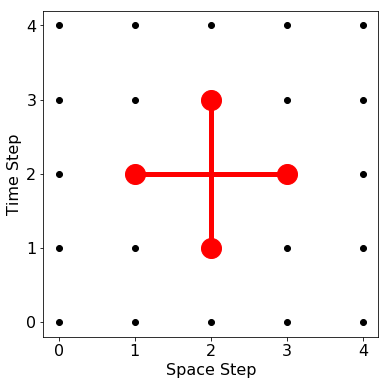

In [101]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
plt.plot(1,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot(2,1,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot([2,2],[1,3],'r-',linewidth=5)

plt.ylabel('Time Step: n',fontsize=16)
plt.yticks(range(5),fontsize=16)
plt.xlabel('Space Step: i',fontsize=16)
plt.xticks(range(5),fontsize=16)


plt.show()

The notation on the right-hand side of equation 14c is a bit cumbersome because one has to write out all of the spatial and temporal dependences.  Thus, there is great advantage in developing some sort of short form. In this case we can switch to index notation where **subscript indices** represent the spatial coordinate (usually the letter $i$) and **superscript indices** represent the temporal coordinate (usually using the letter $n$).  Thus, we can rewrite equation 14c as the following:

$$\frac{\partial U(x,t)}{\partial x}+\frac{\partial U(x,t)}{\partial t} \approx \frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x} + \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2\Delta t} = \frac{1}{2\Delta x}\left(U^n_{i+1}-U^n_{i-1}\right) + \frac{1}{2\Delta t}\left(U^{n+1}_{i}-U^{n-1}_{i}\right), \tag{15a} $$

where in the figure above I have plotted the stencil for $[i,n]=[2,2]$.  Note that compact notation easily can be extended to 2D or 3D spatial dimension scenarios using expressions like:

$$\frac{\partial U(x,y,z,t)}{\partial x}+\frac{\partial U(x,y,z,t)}{\partial t} \approx \frac{1}{2\Delta x}\left(U^n_{i+1,j,k}-U^n_{i-1,j,k}\right) + \frac{1}{2\Delta t}\left(U^{n+1}_{i,j,k}-U^{n-1}_{i,j,k}\right), \tag{15b} $$

which is much more compact that writing out all of the variable dependencies!

# Discretizing the 1D Advection Equation

One of the more straightforward PDEs to think about apply the above numerical derivative schemes to is the [advection equation](https://en.wikipedia.org/wiki/Advection).  This equation represents the transport of a substance or quantity by bulk motion. For example, the advection of pollutants or silt down a river. (Note that this is different than [convection](https://en.wikipedia.org/wiki/Convection) which combines advection with diffusion, which is a much more complex process to model.) 

The PDE governing advection of, say, a pollutant in a stream $U=U(x,t)$ is given by:

$$
\begin{eqnarray}
{\rm PDE:} & \quad & \frac{\partial U}{\partial x} = \frac{1}{c}\frac{\partial U}{\partial t}, \quad x\in[0,1], \quad t\in[0,1] \tag{16a}\\
{\rm Initial Condition:} & \quad & U(x,t=0)= e^{-x^2/10}\tag{16b}\\
{\rm Boundary Conditions:} & \quad & U(x=0,t) = U(x=1,t)=0 \tag{16c}
\end{eqnarray}
$$

where $c$ is the speed of the material transport (e.g., rate of water flow).  Let's also say that we are solving the advection problem on a solution domain $x\in[0,1]$ and $t\in[0,1]$.  Let's also say that the initial condition is that $U(x,t=0)= exp^{-x^2/10}$ and for the boundaries $U(x=0,t)=0$ and $U(x=1,t)=0$. 

## Numerical Solutions

Let's now say that we are looking to solve this equation numerically on a "grid" or "mesh".  In this case we have to choose our **discretization interval**, which effectively is how we sample our numerical solution grid in space and time.  Let's say that we choose $\Delta t = 0.04$ s and $\Delta x = 0.04$ m as our time and space discretization intervals. Since our domains are defined by $x\in[0,1]$ and $t\in[0,1]$, this means that we have $I \times N=26 \times 26$ grid points in our numerical solution.

To illustrate what the solution grids looks like, I plot a graphical representation of it in the figure below. Here, I've plotted two different colors.  The red circles are those points on the solution grid where we already know the solution (i.e., because of the initial and boundary conditions).  The black circles are those points in the solution domain where the solution is unknown. Thus, the goal of computing the finite-difference solution of the PDE is to use the information that is currently defined on the red points to calculate quantities on the black points.

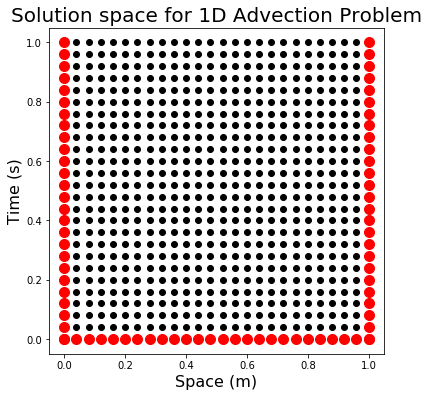

In [77]:
plt.figure(figsize=(6,6))
nx=ny=26
x = np.arange(nx)/(nx-1)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1/(nx-1)
plt.plot(x,np.zeros(ny),'ro',ms=10)
plt.plot(np.zeros(ny),x,'ro',ms=10)
plt.plot(np.zeros(ny)+1,x,'ro',ms=10)    
plt.ylabel('Time (s)',fontsize=16)
plt.xlabel('Space (m)',fontsize=16)
plt.title('Solution space for 1D Advection Problem',fontsize=20)
plt.show()

### Solution by *explicit* finite-difference methods

Let's now think about how we are going to discretize the partial deriatives in equation 16a. Let's say that we want to perform a discretization where we use a **first-order forward difference** in time at each spatial grid point $i$:

$$\frac{\partial U}{\partial t} \approx \frac{U^{n+1}_i - U^{n}_i}{\Delta t}, \tag{17a}$$

and then use a **second-order centered difference** in space at each temporal grid point $n$:

$$\frac{\partial U}{\partial x} \approx \frac{U^{n}_{i+1} - U^{n}_{i-1}}{2\Delta x}. \tag{17b}$$

We can now use these approximations to generate a **finite-difference stencil** representing the 1D advection PDE in equation 16a 

$$\frac{U^{n}_{i+1} - U^{n}_{i-1}}{2\Delta x} = \frac{1}{c}\left(\frac{U^{n+1}_i - U^{n}_i}{\Delta t} \right), \tag{17c}$$

that is first-order accurate in time and second-order accurate in space. A compact way to write this level of accuracy is $\mathcal{O}\left(\Delta t, \Delta x^2  \right)$.

If, for a moment, we assume that $n=0$, we see that we know all of the quantities in equation 17c - except for the value of $U^{n+1}_{i}$.  Thus, let's rearrange equation 17c where all of the unknown terms at time points $n+1$ are on the left and all the known terms at time points $n$ are on the right:

$$U^{n+1}_i  =\frac{c\Delta t}{2\Delta x}\left(U^{n}_{i+1} - U^{n}_{i-1}\right) + U^{n}_i, \tag{17d}$$

or if we define $\gamma = \frac{c\Delta t}{2\Delta x}$, then we have:

$$U^{n+1}_i  =\gamma \left(U^{n}_{i+1} - U^{n}_{i-1}\right) + U^{n}_i, \tag{17d}$$

Because the only unknown grid point is **explictly** defined by all of the other points, this type of approach is called an **explict finite-difference solution.** Graphically, this stencil centered about $[i,n]=[2,2]$ looks like the following :

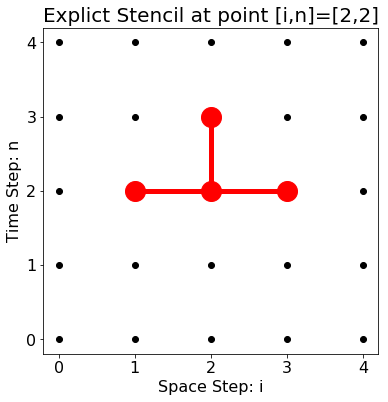

In [99]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
    
# . . Solution at point i
plt.plot(1,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot(2,2,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot([2,2],[2,3],'r-',linewidth=5)

plt.ylabel('Time Step: n',fontsize=16)
plt.yticks(range(5),fontsize=16)
plt.xlabel('Space Step: i',fontsize=16)
plt.xticks(range(5),fontsize=16)

plt.title('Explict Stencil at point [i,n]=[2,2]',fontsize=20)
plt.show()

In the above figure I have simply chosen a value of $[i,n]=[2,2]$; however, this **stencil** is also applicable to all of the other points in the grid.  For example, one can think of stencils at neighbouring points  $[i,n]=[1,2]$ and  $[i,n]=[3,2]$ to be very similar!

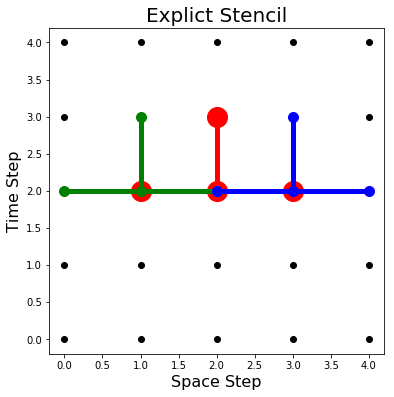

In [89]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
    
# . . Solution at point i
plt.plot(1,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot(2,2,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot([2,2],[2,3],'r-',linewidth=5)

# . . Solution at point i-1
plt.plot(0,2,'go',ms=10)
plt.plot(2,2,'go',ms=10)
plt.plot([0,2],[2,2],'g-',linewidth=5)
plt.plot(1,2,'go',ms=10)
plt.plot(1,3,'go',ms=10)
plt.plot([1,1],[2,3],'g-',linewidth=5)



# . . Solution at point i+1
plt.plot(2,2,'bo',ms=10)
plt.plot(4,2,'bo',ms=10)
plt.plot([2,4],[2,2],'b-',linewidth=5)
plt.plot(3,2,'bo',ms=10)
plt.plot(3,3,'bo',ms=10)
plt.plot([3,3],[2,3],'b-',linewidth=5)


plt.ylabel('Time Step',fontsize=16)
plt.xlabel('Space Step',fontsize=16)
plt.title('Explict Stencil',fontsize=20)
plt.show()

This is, in fact, why it is called a **stencil**: you can move it around the computational mesh, but the shape doesn't change!

### A Linear Algebra Framework

The shifting stencils in figure above actually are a **system of linear equations** that can be represented in a straightforward manner using matrix algebra in the form of ${\bf Ax}={\bf b}$ where ${\bf m}$ is the vector of $I$ unknown values $U^{n+1}_i$ on the left-hand side of equation 17d, ${\bf b}$ is a vector of $I$ known values on the right-hand side of equation 17d, and ${\bf A}$ is a matrix that represents the mapping between ${\bf m}$ and ${\bf d}$.  Let's write this out explicitly:

$${\bf Ax} = {\bf b} $$

which corresponds to

$$
\left[
\begin{array}{ccccccc}
1 & 0 & 0 & ... & 0 &0 &0 \\
0 & 1 & 0 & ... & 0 &0 &0 \\
0 & 0 & 1 & ... & 0 &0 &0 \\
\vdots & \vdots & \vdots & \ddots & \vdots &\vdots &\vdots \\
0 &0&0&...&1&0&0\\
0 &0&0&...&0&1&0\\
0 &0&0&...&0&0&1\\
\end{array}
\right]
\left[
\begin{array}{c}
U^{n+1}_0 \\
U^{n+1}_1 \\
U^{n+1}_2 \\
\vdots\\
U^{n+1}_{I-2} \\
U^{n+1}_{I-1} \\
U^{n+1}_{I} \\
\end{array}
\right]
=
\left[
\begin{array}{c}
\gamma \left(U^{n}_{1} - U^{n}_{-1}\right) + U^{n}_{0} \\
\gamma \left(U^{n}_{2} - U^{n}_{0}\right) + U^{n}_{1} \\
\gamma \left(U^{n}_{3} - U^{n}_{1}\right) + U^{n}_{2} \\
\vdots\\
\gamma \left(U^{n}_{I-1} - U^{n}_{I-3}\right) + U^{n}_{I-2} \\
\gamma \left(U^{n}_{I}   - U^{n}_{I-2}\right) + U^{n}_{I-1} \\
\gamma \left(U^{n}_{I+1} - U^{n}_{I-1}\right) + U^{n}_{I} \\
\end{array}
\right]
$$